In [3]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [57]:
import keras
from keras.layers import Input,Dense,Flatten,Conv2D,MaxPool2D,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras import models
from keras import Model
import keras_tuner as kt
import tensorflow as tf
from keras import Sequential
from  keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import L1,L2



In [58]:
# rescaling the images or data agumentation
train = ImageDataGenerator(rotation_range=90,horizontal_flip=True,vertical_flip=True,rescale=1./255)
test = ImageDataGenerator(rescale=1./255)

In [63]:
# image data generator
traing = train.flow_from_directory("/kaggle/input/animal-faces/afhq/train",target_size=(224,224),class_mode="categorical",batch_size=10)
testg= test.flow_from_directory("/kaggle/input/animal-faces/afhq/val",target_size=(224,224),class_mode="categorical",batch_size=10)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


# sequential api model

In [60]:
from keras.applications import VGG16,VGG19,ResNet50

In [64]:
model_1 = Sequential()
model_1.add(Conv2D(20, (3,3), activation='relu', input_shape=(224, 224, 3)))
model_1.add(Conv2D(20, (3,3), activation='relu'))
model_1.add(MaxPool2D((2,2), padding='valid'))

model_1.add(Conv2D(50, (3,3), activation='relu'))
model_1.add(Conv2D(50, (3,3), activation='relu'))
model_1.add(MaxPool2D(2,2))

model_1.add(Flatten())
model_1.add(Dense(3, activation='softmax'))

In [65]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 20)      560       
                                                                 
 conv2d_31 (Conv2D)          (None, 220, 220, 20)      3620      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 110, 110, 20)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 108, 108, 50)      9050      
                                                                 
 conv2d_33 (Conv2D)          (None, 106, 106, 50)      22550     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 53, 53, 50)        0         
 ng2D)                                               

In [66]:
model_1.layers

In [67]:
# callbacks of early stopping
early_stop= EarlyStopping(monitor="val_loss",min_delta=0.01,patience=3,verbose=1,start_from_epoch=3)

In [68]:
#compile model
model_1.compile(loss="categorical_crossentropy", optimizer= Adam(), metrics=["accuracy","mse"])


In [69]:
hist = model_1.fit(
  traing,
  validation_data = testg,
  epochs = 5,
  steps_per_epoch = len(traing),
  validation_steps = len(testg),
    callbacks=early_stop
)

Epoch 1/5
1463/1463 [==============================] - 194s 131ms/step - loss: 8.4033 - accuracy: 0.5853 - mse: 0.2489 - val_loss: 18.4090 - val_accuracy: 0.6833 - val_mse: 0.2082
Epoch 2/5
1463/1463 [==============================] - 183s 125ms/step - loss: 290.2118 - accuracy: 0.6675 - mse: 0.2212 - val_loss: 344.2041 - val_accuracy: 0.6933 - val_mse: 0.2043
Epoch 3/5
1463/1463 [==============================] - 183s 125ms/step - loss: 347.3624 - accuracy: 0.7207 - mse: 0.1860 - val_loss: 876.5873 - val_accuracy: 0.6747 - val_mse: 0.2168
Epoch 4/5
1463/1463 [==============================] - 186s 127ms/step - loss: 1462.8560 - accuracy: 0.7235 - mse: 0.1843 - val_loss: 2280.2744 - val_accuracy: 0.7347 - val_mse: 0.1769
Epoch 5/5
1463/1463 [==============================] - 180s 123ms/step - loss: 3619.6604 - accuracy: 0.7410 - mse: 0.1727 - val_loss: 3971.3533 - val_accuracy: 0.7707 - val_mse: 0.1529


In [70]:
def plot_metric(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

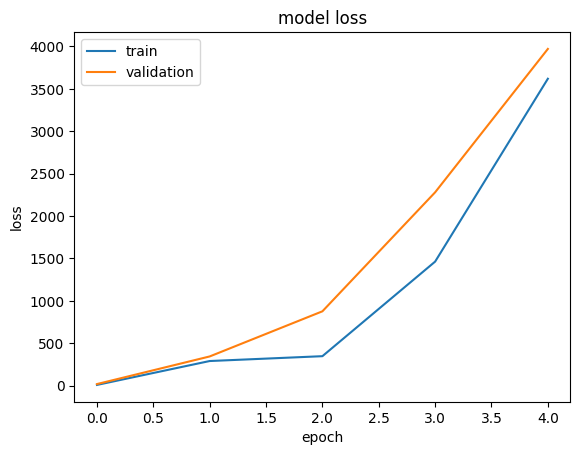

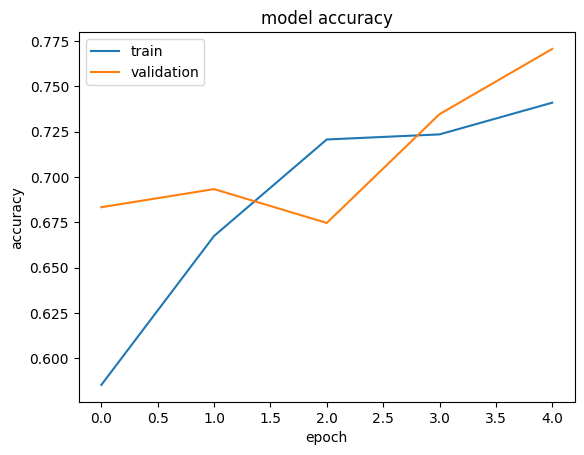

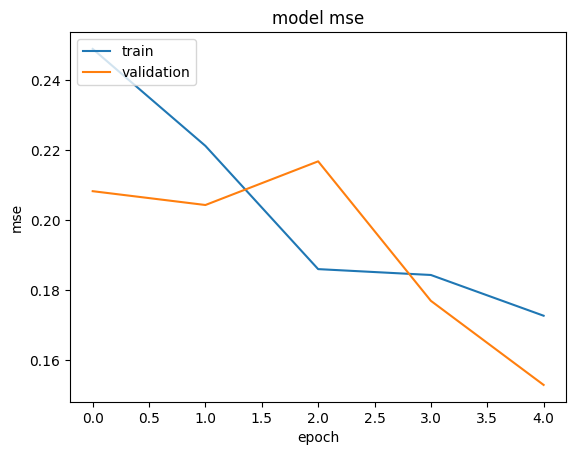

In [71]:
plot_metric(hist, "loss")
plot_metric(hist, "accuracy")
plot_metric(hist, "mse")

In [72]:
#  prediction of the test or unseen data
predicted_yi = model_1.predict(testg)

150/150 [==============================] - 4s 28ms/step


In [73]:
# converting the probabilities 
final_yi_pred = np.argmax(predicted_yi,axis=1)

In [74]:
final_yi_pred

array([1, 1, 2, ..., 1, 0, 2])

In [75]:
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(testg.labels,final_yi_pred)

0.3353333333333333

In [76]:
final_scores = model_1.evaluate(testg)

150/150 [==============================] - 4s 29ms/step - loss: 3971.3538 - accuracy: 0.7707 - mse: 0.1529


In [77]:
# Calculate accuracy
accuracy = np.mean(final_yi_pred == testg.labels)

print(f"Accuracy on test data: {accuracy * 100:.2f}%")

Accuracy on test data: 33.53%


#  functional api  model 2

In [78]:
# creating the object to the classof VGG16
# Load the InceptionV3 model pre-trained on ImageNet data
vgg_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))

# Freeze the convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

In [92]:
vgg_model.layers

In [108]:
vgg_model.layers[18]

In [121]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.2)(x)

prediction = Dense(3, activation="softmax")(x)

model_2 = Model(inputs=vgg_model.input, outputs=prediction)

model_2.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

In [122]:
# callbacks of early stopping
early_stop= EarlyStopping(monitor="val_loss",min_delta=0.01,patience=3,verbose=1,start_from_epoch=3)

In [ ]:
hist = model_2.fit(
  traing,
  validation_data = testg,
  epochs = 5,
  steps_per_epoch = len(traing),
  validation_steps = len(testg),
    callbacks=early_stop
)

In [ ]:
plot_metric(hist, "loss")
plot_metric(hist, "accuracy")
plot_metric(hist, "mse")

In [ ]:
# prediction of the test data
functional_model_predicted = model_2.predict(testg)

In [ ]:
# converting the predicted probabilities values to 
final_predicted_values = np.argmax(functional_model_predicted,axis=1)

In [ ]:
final_predicted_values

In [ ]:
scores_tf = model_2.evaluate(testg)


In [ ]:
accuracy_score(testg.labels,final_predicted_values)